Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [103]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [104]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [105]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train")
data_dir_test = pathlib.Path('/Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Test')

In [106]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [107]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [136]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset="training",
    seed=123,  # Ensures reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

# Display class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Verify dataset shape
for image_batch, labels_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {labels_batch.shape}")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


In [137]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,  # Ensures reproducibility
    validation_split = 0.2,
    subset="validation",
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

# Display class names
class_names = val_ds.class_names
print(f"Class names: {class_names}")

# Verify dataset shape
for image_batch, labels_batch in val_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {labels_batch.shape}")
    

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


In [113]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

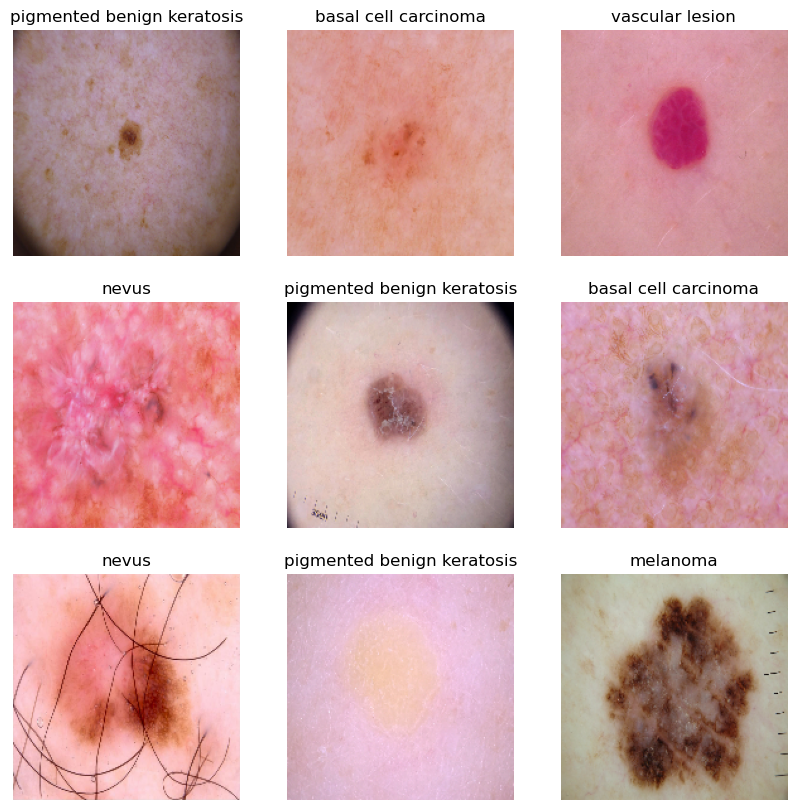

In [138]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to numpy
            plt.title(class_names[labels[i]])  # Display class name
            plt.axis("off")  # Hide axis
    plt.show()

# Visualize training dataset
visualize_images(train_ds)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [115]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
# Normalize images to [0,1] using a Rescaling layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [121]:
### Your code goes here
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [122]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
# View the summary of all layers
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [124]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - accuracy: 0.1849 - loss: 2.2013 - val_accuracy: 0.2707 - val_loss: 1.9662
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.2559 - loss: 2.0077 - val_accuracy: 0.3624 - val_loss: 1.8665
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.3445 - loss: 1.8208 - val_accuracy: 0.3870 - val_loss: 1.7187
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.3583 - loss: 1.7512 - val_accuracy: 0.4407 - val_loss: 1.6127
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.4152 - loss: 1.6591 - val_accuracy: 0.4832 - val_loss: 1.5113
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.4669 - loss: 1.5695 - val_accuracy: 0.4877 - val_loss: 1.5361
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - accuracy: 0.4839 - loss: 1.5265 - val_accuracy: 0.4787 - val_loss: 1.5186
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.4531 - loss: 1.5270 - val_accu

In [126]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.5920 - loss: 1.1224 - val_accuracy: 0.5347 - val_loss: 1.4437
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.6167 - loss: 1.1118 - val_accuracy: 0.4855 - val_loss: 1.5043
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.5779 - loss: 1.2133 - val_accuracy: 0.5593 - val_loss: 1.3739
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.6262 - loss: 1.0198 - val_accuracy: 0.5369 - val_loss: 1.5354
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.6276 - loss: 1.0464 - val_accuracy: 0.5481 - val_loss: 1.4557
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6732 - loss: 0.8929 - val_accuracy: 0.5391 - val_loss: 1.5849
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6626 - loss: 0.9505 - val_accuracy: 0.5570 - val_loss: 1.6150
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.6588 - loss: 0.9061 - val_accu

### Visualizing training results

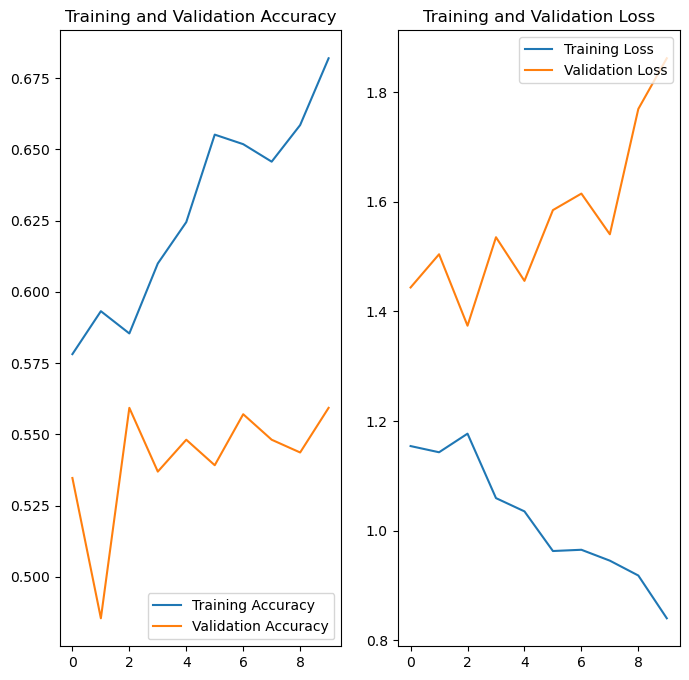

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Findings After Model Training
### 1. Training vs. Validation Accuracy
The training accuracy steadily increases from 59.2% (Epoch 1) to 68.4% (Epoch 10).
However, the validation accuracy fluctuates around 53-56% and does not improve significantly.
This indicates a potential overfitting issue—the model learns well on training data but struggles to generalize to unseen data.
### 2. Loss Analysis
Training loss decreases steadily from 1.1224 to 0.8382, showing that the model is learning patterns in the training set.
Validation loss increases from 1.4437 to 1.8619, indicating that the model is not performing well on the validation set.
A rising validation loss while training loss decreases is a clear sign of overfitting.

In [139]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Use it before feeding data into the model
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


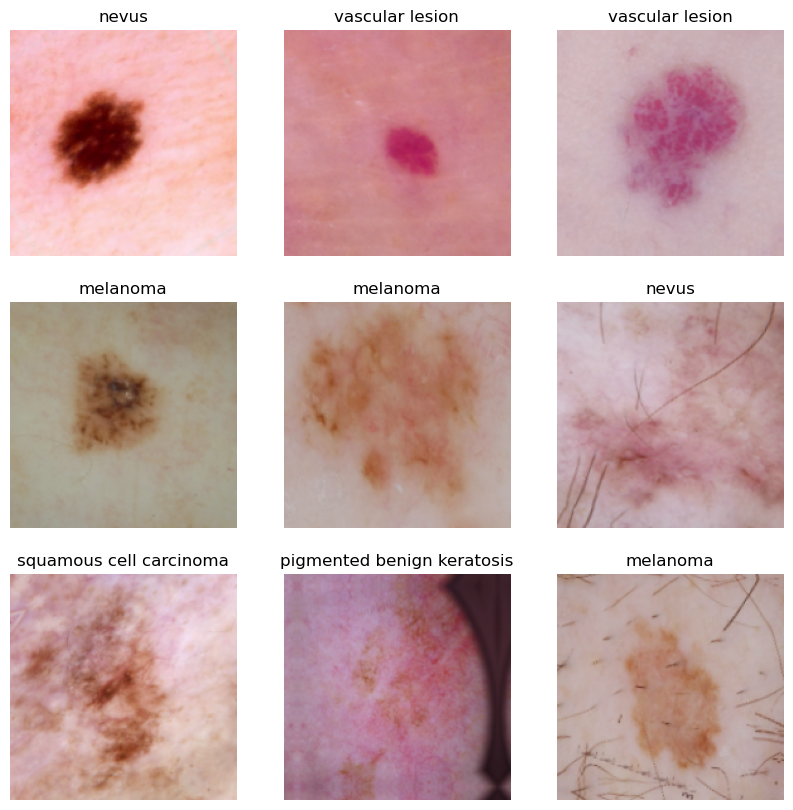

In [140]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
visualize_images(augmented_train_ds)

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Added dropout to the first block

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Added dropout to the second block

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),  # Increased dropout for deeper layers

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Final dropout before output layer
    Dense(9, activation='softmax')
])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [141]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [142]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 392ms/step - accuracy: 0.3180 - loss: 112.5264 - val_accuracy: 0.1611 - val_loss: 2.1239
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - accuracy: 0.1688 - loss: 2.8870 - val_accuracy: 0.1544 - val_loss: 2.1134
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.1709 - loss: 2.0952 - val_accuracy: 0.1544 - val_loss: 2.0987
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.1606 - loss: 2.0912 - val_accuracy: 0.2125 - val_loss: 2.0817
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.2066 - loss: 2.0794 - val_accuracy: 0.2058 - val_loss: 2.0842
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.2018 - loss: 2.0666 - val_accuracy: 0.2103 - val_loss: 2.0684
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.2094 - loss: 2.0599 - val_accuracy: 0.2103 - val_loss: 2.0611
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.2047 - loss: 2.0442 - val_accuracy: 0.2

### Visualizing the results

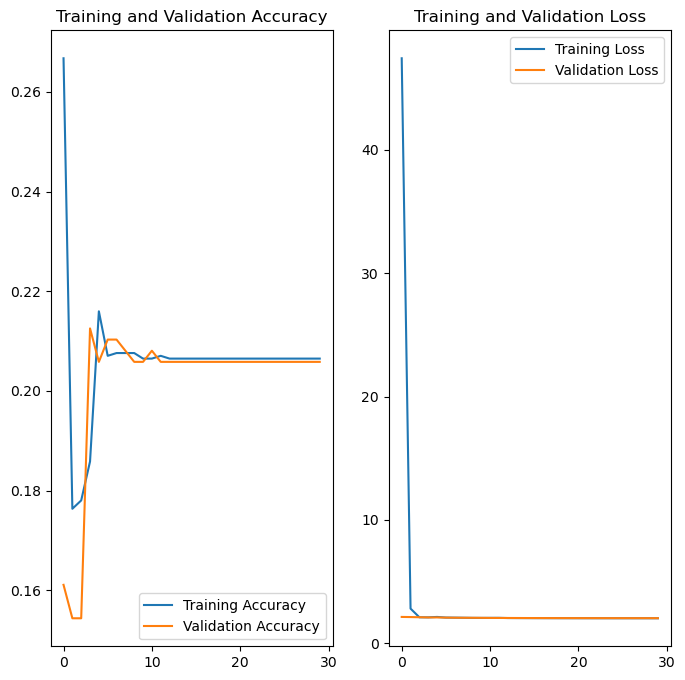

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## model fit findings
From the accuracy and loss, it is clear that model is underfitting significantly

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

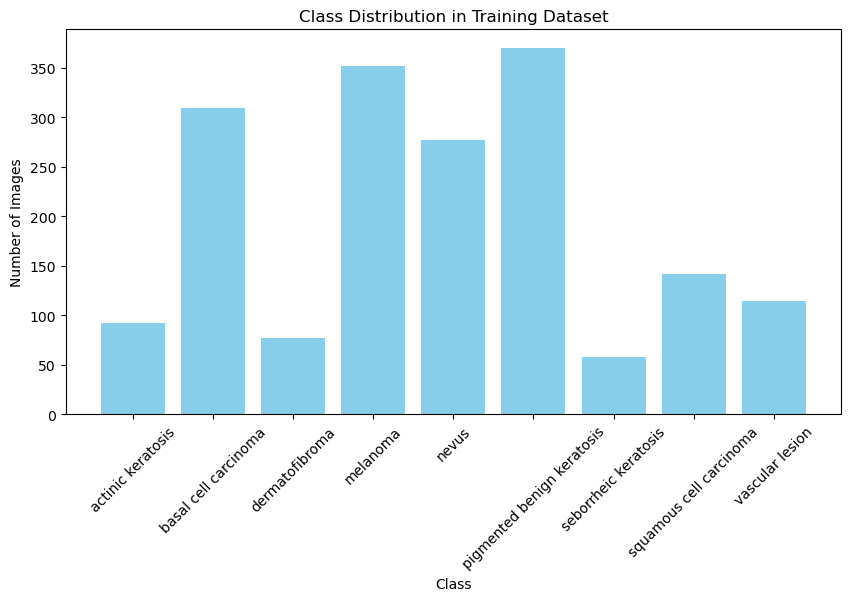

In [144]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_ds is already defined

num_classes = len(class_names)

# Count occurrences of each class in train_ds
class_counts = np.zeros(num_classes)

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

#### Looking at the plot it is clear that class distribution is uneven 
#### - Which class has the least number of samples? seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? pigmented benign keratosis 


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
from pathlib import Path
path_to_training_dataset= Path(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x299946570>: 100%|██████████| 500/500 [00:02<00:00, 199.12 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x299A68080>: 100%|██████████| 500/500 [00:02<00:00, 215.96 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x298B2F530>: 100%|██████████| 500/500 [00:02<00:00, 208.75 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=944x1127 at 0x298A05A30>: 100%|██████████| 500/500 [00:09<00:00, 50.32 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1753E3E00>: 100%|██████████| 500/500 [00:09<00:00, 54.20 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x299ADECF0>: 100%|██████████| 500/500 [00:02<00:00, 196.50 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2927F43E0>: 100%|██████████| 500/500 [00:04<00:00, 103.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2988AAD50>: 100%|██████████| 500/500 [00:02<00:00, 206.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/amitkumar/noumena/AIML/Melanoma-Detection/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x299AB26F0>: 100%|██████████| 500/500 [00:02<00:00, 210.82 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [58]:
train_ds_balanced = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,  # Ensures reproducibility
    image_size=(img_height, img_width),  # Resize images
    batch_size=batch_size
)

# Display class names
class_names = train_ds_balanced.class_names
print(f"Class names: {class_names}")

# Verify dataset shape
for image_batch, labels_batch in train_ds_balanced.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {labels_batch.shape}")

Found 6739 files belonging to 9 classes.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


2025-03-17 20:12:16.346069: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


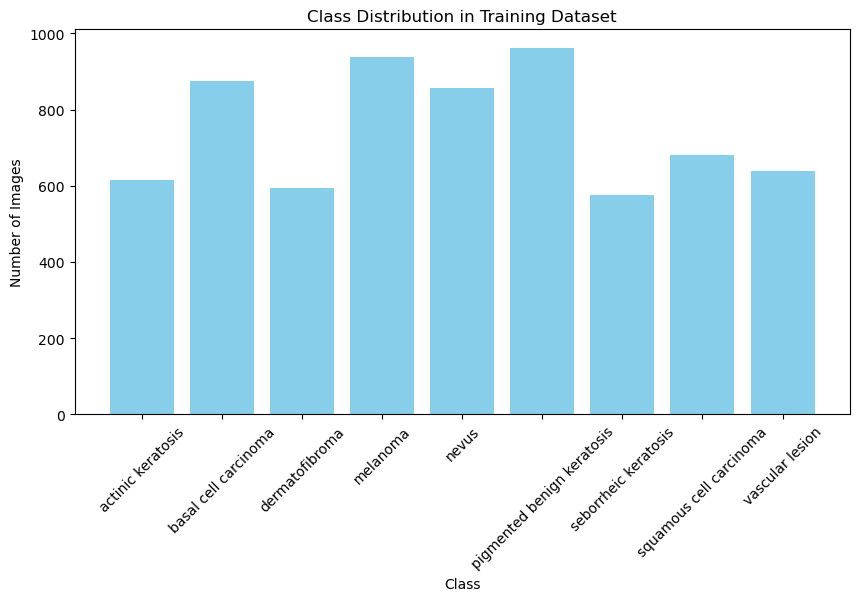

In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_ds is already defined

num_classes = len(class_names)

# Count occurrences of each class in train_ds
class_counts = np.zeros(num_classes)

for images, labels in train_ds_balanced:
    for label in labels.numpy():
        class_counts[label] += 1

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [78]:
data_dir_train= data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define image augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Use it before feeding data into the model
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

#### **Todo:** Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [82]:
# Normalize images to [0,1] using a Rescaling layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#### **Todo:** Create your model (make sure to include normalization)

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define CNN architecture with Batch Normalization
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Dropout(0.3),  

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),  

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),  

    Flatten(),
    Dropout(0.5),  
    Dense(256, activation='relu'),
    Dropout(0.3),  
    Dense(9, activation='softmax')
])

model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,017 (50.37 MB)

 Trainable params: 13,203,017 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [100]:
## your code goes here
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [101]:
epochs = 40
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 414ms/step - accuracy: 0.1758 - loss: 2.0882 - val_accuracy: 0.3044 - val_loss: 1.7627
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 434ms/step - accuracy: 0.3099 - loss: 1.7423 - val_accuracy: 0.3534 - val_loss: 1.6266
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 464ms/step - accuracy: 0.3742 - loss: 1.6232 - val_accuracy: 0.3697 - val_loss: 1.6931
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 446ms/step - accuracy: 0.4406 - loss: 1.4771 - val_accuracy: 0.4454 - val_loss: 1.4553
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 434ms/step - accuracy: 0.4684 - loss: 1.4030 - val_accuracy: 0.5115 - val_loss: 1.3060
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 431ms/step - accuracy: 0.5151 - loss: 1.2828 - val_accuracy: 0.5367 - val_loss: 1.2612
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 411ms/step - accuracy: 0.5273 - loss: 1.2395 - val_accuracy: 0.5442 - val_loss: 1.2802
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 403ms/step - accuracy: 0.5540 - loss: 1

#### **Todo:**  Visualize the model results

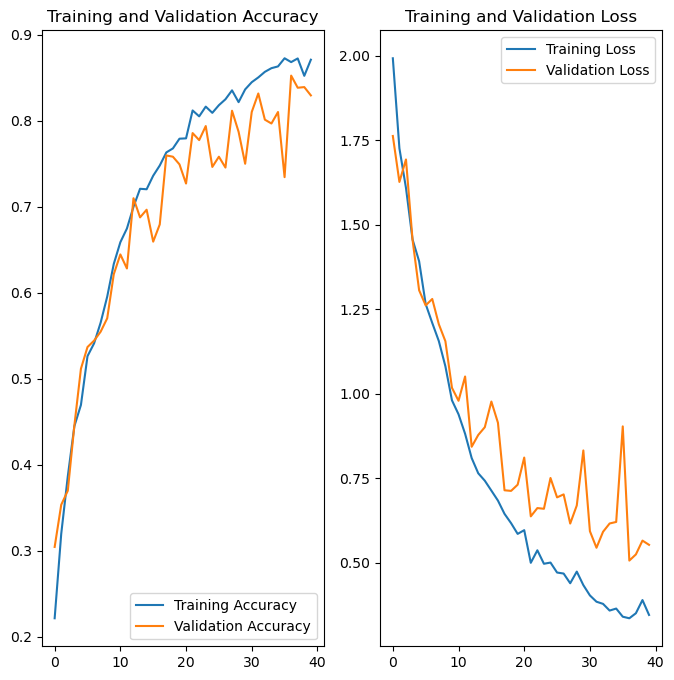

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Analysis of Model Performance
## 1. Overfitting vs. Underfitting
- Overfitting Reduced:
Earlier, validation loss was increasing while training loss was decreasing (a sign of overfitting).
Now, validation accuracy has improved significantly and is more aligned with training accuracy.
Training accuracy: 86.8%
Validation accuracy: 82.9%

## 2. Impact of Class Rebalancing
Validation accuracy increased steadily after epoch 28, reaching 85.2% (epoch 37) before slightly dropping.
Validation loss also decreased significantly (from 0.9031 → 0.5059).
This suggests that class rebalancing helped the model learn better representations, reducing bias toward majority classes.
